<a href="https://colab.research.google.com/github/devparikh0506/DATA_690_Deep_Learning/blob/main/week_4/FeedForwardNeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## [source](https://github.com/bufuchangfeng/NeuralNetwork/blob/nn/nn_and_cnn.ipynb)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
np.random.seed(42)

In [ ]:
def load_data(path):
    """Loads the MNIST dataset and splits it into training and testing sets.

    Args:
        path (str): Path to the MNIST dataset file.

    Returns:
        Tuple: (x_train, y_train, x_test, y_test)
    """
    with np.load(path) as f:
        # Load training data and labels
        x_train, y_train = f['x_train'], f['y_train']
        # Load testing data and labels
        x_test, y_test = f['x_test'], f['y_test']
        return x_train, y_train, x_test, y_test

# Load MNIST dataset
train_data, train_label, test_data, test_label = load_data('/content/drive/MyDrive/DATA-690-deep-learning/data/mnist.npz')

In [ ]:
# normalize the image data
X_train = (train_data/255 - 0.5)*2
X_test = (test_data/255 - 0.5)*2

In [ ]:
X_train.shape

(60000, 28, 28)

In [ ]:
#Reshape the training data to have a channel dimension
train_data = X_train.reshape(-1, 1, 28, 28)

In [ ]:
train_label.shape

(60000,)

In [ ]:
X_test.shape

(10000, 28, 28)

In [ ]:
test_data = X_test.reshape(-1, 1, 28, 28)

In [ ]:
train_data, valid_data, train_label, valid_label = train_test_split(train_data, train_label, test_size=0.2, random_state=42)

In [ ]:
train_data.shape

(48000, 1, 28, 28)

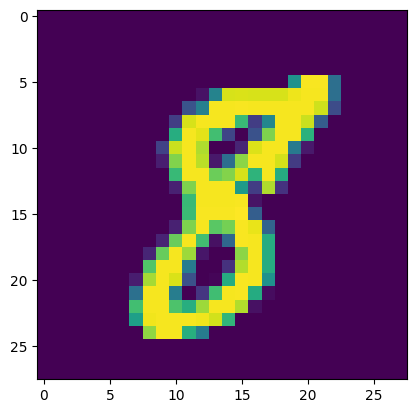

In [ ]:
plt.imshow(valid_data[2].reshape(28, 28))
plt.show()


In [ ]:
valid_label[2]

8

In [ ]:
def label_to_one_hot(y, n_class):
    """Converts labels to one-hot encoding.

    Args:
        y (numpy.ndarray): Array of labels.
        n_class (int): Number of classes.

    Returns:
        numpy.ndarray: One-hot encoded labels.
    """
    one_hot = np.zeros((y.shape[0], n_class))
    for i in range(len(y)):
        one_hot[i][int(y[i])] = 1

    return one_hot

In [ ]:
# prompt: provide a generator to provide data as batches to  model

def data_generator(data, label, batch_size):
  """
  Generates batches of data and labels.

  Args:
    data: The input data.
    label: The corresponding labels.
    batch_size: The size of each batch.

  Yields:
    A tuple of (data_batch, label_batch).
  """
  num_samples = len(data)
  num_batches = num_samples // batch_size

  for i in range(num_batches):
    start = i * batch_size
    end = (i + 1) * batch_size
    yield data[start:end], label[start:end]

  # If there are remaining samples, yield a smaller batch.
  if num_samples % batch_size != 0:
    yield data[num_batches * batch_size:], label[num_batches * batch_size:]


In [ ]:
class Layer(ABC):
  """The base class for NN model layer."""
  def __init__(self):
      super.__init__()

  @abstractmethod
  def forward(self, x):
    raise NotImplementedError

  @abstractmethod
  def backward(self, dout):
    raise NotImplementedError

# Weight initialization function

In [ ]:
def he_uniform(weight_shape):
    """
    Uniform(-b, b), b=sqrt(6/fan_in)
    Args:
        weight_shape: the shape of weight, for example (784, 300)
    """
    fan_in, fan_out = weight_shape
    b = np.sqrt(6 / fan_in)
    return np.random.uniform(-b, b, size=weight_shape)

In [ ]:
class Linear(Layer):
    def __init__(self, input_dim, output_dim):
        self.params = {}
        self.params['W'] = he_uniform((input_dim, output_dim))
        self.params['b'] = np.random.randn(output_dim)

        self.grads = {}

    def forward(self, x):

        self.x = x

        out = np.dot(x, self.params['W']) + self.params['b']
        return out

    def backward(self, dout):

        self.grads['W'] = np.dot(self.x.T, dout)
        self.grads['b'] = np.sum(dout, axis=0)

        return np.dot(dout, self.params['W'].T)

# Adding Sigmoid Layer

In [ ]:
class Sigmoid(Layer):
    def __init__(self):
        self.params = None
        self.out = None

    def forward(self, x):
        self.out = 1 / (1 + np.exp(-x))
        return self.out

    def backward(self, dout):
        dx = dout * ( 1 - self.out) * self.out
        return dx

In [ ]:
class ReLU(Layer):
    def __init__(self):
        self.params = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0

        return dout

In [ ]:
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return e_x / e_x.sum(axis=-1, keepdims=True)

In [ ]:
class SoftmaxWithCrossEntropyLoss(Layer):
    def __init__(self):
        self.params = None

    def forward(self, out, y):
        '''
            out: output of last fully connected layer
            y: true label
        '''

        batch_size = out.shape[0]

        # max_val = np.max(out, axis=1).reshape(-1, 1)
        # # print(out)
        # # print(max_val)
        # exp_out = np.exp(out - max_val)
        # sum_exp_out = np.sum(exp_out, axis=1).reshape(-1, 1)
        # out = exp_out / sum_exp_out

        out = softmax(out)

        self.out = out
        self.y = y

        log_out = np.log(out + 1e-7)

        loss = np.sum(-log_out * y)

        return loss / batch_size, out

    def backward(self, dout):
        return (self.out - self.y) / batch_size

In [ ]:
class FNN(Layer):
    def __init__(self):
        self.layers = []
        self.layers.append(Linear(784, 512)) # Changed first layer
        self.layers.append(Sigmoid()) # changed ReLU to Sigmoid
        self.layers.append(Linear(512, 256)) # added new hidden layer
        self.layers.append(Sigmoid()) # changed ReLU to Sigmoid
        self.layers.append(Linear(256, 128)) # modified hidden layer
        self.layers.append(Sigmoid()) # changed ReLU to Sigmoid
        self.layers.append(Linear(128, 64))  # modified hidden layer
        self.layers.append(Sigmoid()) # changed ReLU to Sigmoid
        self.layers.append(Linear(64, 10))  # modified ouput layer
        self.layers.append(SoftmaxWithCrossEntropyLoss())


    def forward(self, x, y):
        batch_size = x.shape[0]

        y = label_to_one_hot(y, 10)

        x = x.reshape(batch_size, 784)

        for layer in self.layers[:-1]:
            x = layer.forward(x)

        return self.layers[-1].forward(x, y)


    def backward(self):
        dout = 1
        for layer in self.layers[::-1]:
            dout = layer.backward(dout)

    def save(self, filepath):
        """
        Saves the parameters of the model to a .npz file.
        """
        params = {}
        for i, layer in enumerate(self.layers):
            if hasattr(layer, 'params') and layer.params is not None:
                for j, param in enumerate(layer.params):
                    params[f'layer_{i}_param_{j}'] = param

        np.savez(filepath, **params)
        print(f"Model parameters saved to {filepath}")

    def load(self, filepath):
        """
        Loads the parameters of the model from a npz file.
        """
        if not os.path.exists(filepath):
            raise FileNotFoundError(f"No file found at {filepath}")

        params = np.load(filepath)
        for i, layer in enumerate(self.layers):
            if hasattr(layer, 'params') and layer.params is not None:
                for j in range(len(layer.params)):
                    param_name = f'layer_{i}_param_{j}'
                    if param_name in params:
                        layer.params[j] = params[param_name]
                    else:
                        print(f"Warning: {param_name} not found in the loaded file")

        print(f"Model parameters loaded from {filepath}")

In [ ]:
class Optimizer(ABC):
    """The base class for optimizer."""
    def __init__(self, learning_rate, layers):
        super().__init__()

    @abstractmethod
    def update(self):
        raise NotImplementedError

In [ ]:
class SGD(Optimizer):
    """SGD (Stochastic gradient descent) optimizer"""
    def __init__(self, learning_rate, layers):
        self.learning_rate = learning_rate
        self.layers = layers

    def update(self):
        for i in range(len(self.layers)):
          layer = self.layers[i]
          if layer.params is not None:
            for key in layer.params.keys():
              layer.params[key] -= self.learning_rate * layer.grads[key]

In [ ]:
def train_and_valid(model, optimizer, train_data, train_label, valid_data, valid_label, epochs, batch_size):
  """
  Trains and validates a neural network model.

  Args:
    model: The neural network model.
    optimizer: The optimizer used for training.
    train_data: The training data.
    train_label: The training labels.
    valid_data: The validation data.
    valid_label: The validation labels.
    epochs: The number of training epochs.
    batch_size: The batch size for training.
  """
  for epoch in range(epochs):
    # Shuffle training data for each epoch
    train_data, train_label = shuffle(train_data, train_label)

    # Training loop
    train_loss = 0
    train_correct = 0
    for data_batch, label_batch in data_generator(train_data, train_label, batch_size):
      loss, output = model.forward(data_batch, label_batch)
      train_loss += loss
      train_correct += np.sum(np.argmax(output, axis=1) == label_batch)
      model.backward()
      optimizer.update()

    # Validation loop
    valid_loss = 0
    valid_correct = 0
    for data_batch, label_batch in data_generator(valid_data, valid_label, batch_size):
      loss, output = model.forward(data_batch, label_batch)
      valid_loss += loss
      valid_correct += np.sum(np.argmax(output, axis=1) == label_batch)

    print(f'Epoch: {epoch + 1}/{epochs}, Train Loss: {train_loss / len(train_data):.4f}, Train Acc: {train_correct / len(train_data):.4f}, Valid Loss: {valid_loss / len(valid_data):.4f}, Valid Acc: {valid_correct / len(valid_data):.4f}')

In [ ]:
def test(model, test_data, test_label, batch_size=1):
  """
  Tests the neural network model on the test dataset.

  Args:
    model: The neural network model.
    test_data: The test data.
    test_label: The test labels.
    batch_size: The batch size for testing.
  """
  test_correct = 0
  for data_batch, label_batch in data_generator(test_data, test_label, batch_size):
    _, output = model.forward(data_batch, label_batch)
    test_correct += np.sum(np.argmax(output, axis=1) == label_batch)

  print(f'Test Acc: {test_correct / len(test_data):.4f}')


In [ ]:
model_fnn = FNN()
learning_rate = 5e-3
epochs = 10
batch_size = 256
optimizer = SGD(learning_rate, model_fnn.layers)

train_and_valid(model_fnn, optimizer, train_data, train_label, valid_data, valid_label, epochs, batch_size)


Epoch: 1/10, Train Loss: 0.0096, Train Acc: 0.1075, Valid Loss: 0.0091, Valid Acc: 0.1102
Epoch: 2/10, Train Loss: 0.0090, Train Acc: 0.1129, Valid Loss: 0.0090, Valid Acc: 0.1102
Epoch: 3/10, Train Loss: 0.0090, Train Acc: 0.1129, Valid Loss: 0.0090, Valid Acc: 0.1102
Epoch: 4/10, Train Loss: 0.0090, Train Acc: 0.1129, Valid Loss: 0.0090, Valid Acc: 0.1102
Epoch: 5/10, Train Loss: 0.0090, Train Acc: 0.1129, Valid Loss: 0.0090, Valid Acc: 0.1102
Epoch: 6/10, Train Loss: 0.0090, Train Acc: 0.1129, Valid Loss: 0.0090, Valid Acc: 0.1102
Epoch: 7/10, Train Loss: 0.0090, Train Acc: 0.1129, Valid Loss: 0.0090, Valid Acc: 0.1102
Epoch: 8/10, Train Loss: 0.0090, Train Acc: 0.1129, Valid Loss: 0.0090, Valid Acc: 0.1102
Epoch: 9/10, Train Loss: 0.0090, Train Acc: 0.1129, Valid Loss: 0.0090, Valid Acc: 0.1102
Epoch: 10/10, Train Loss: 0.0090, Train Acc: 0.1129, Valid Loss: 0.0090, Valid Acc: 0.1102


In [ ]:
# Saving the model

file = 'model_fnn.npz'
model_fnn.save(file)

Model parameters saved to model_fnn.npz


In [ ]:
# Loading model
file = 'model_fnn.npz'
loaded_model = FNN()
loaded_model.load(file)

Model parameters loaded from model_fnn.npz


In [ ]:
test(model_fnn, test_data, test_label)

Test Acc: 0.1135


In [ ]:
test(loaded_model, test_data, test_label)

Test Acc: 0.0974
